In [1]:
validation_set_size = 25
IMAGE_SIZE = 64
pixel_size = 1.14e-7

In [ ]:
#@title Install packages
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3
    !pip install --upgrade scipy
    #!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
    #!apt install texlive-science

import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import scipy.io as spio
import re
from matplotlib import colors
from cycler import cycler
from google.colab import drive

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [3]:
"""Importing the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

# Load a matfile with "downsized" ROI:s around particles found in the experimental data 
# Download mat-file from shared drive to your private one if to run in Colab!]

def load_all_data_to_dict(filenames):
  filenames = sorted([filename for filename in filenames if (".mat" in filename)])
  paths_with_zero = [file for file in filenames if re.search('.*0.mat', file)]
  paths_without_zero = [file for file in filenames if not re.search('.*0.mat', file) and re.search('.*.mat', file)]

  p1 = [re.sub('0.mat', '', path_with_zero) for path_with_zero in paths_with_zero]
  p2 = [re.sub('.mat', '', path_without_zero) for path_without_zero in paths_without_zero]
  one_part_sets = list(set(p2).difference(p1))
  two_part_sets = list(set(p1).intersection(p2))

  data = {}

  for file_name in one_part_sets:
    traces = spio.loadmat(data_path + file_name + '.mat', simplify_cells=True)['CompletedTraces']
    name = re.search('^[0-9]{,3}', file_name).group() + 'pct' + re.search('_.{,2}Gold', file_name).group()
    data[name] = traces

  for file_name in two_part_sets:
    first_part = spio.loadmat(data_path + file_name + '0.mat', simplify_cells=True)['CompletedTraces']
    second_part = spio.loadmat(data_path + file_name + '.mat', simplify_cells=True)['CompletedTraces']
    name = re.search('^[0-9]{,3}', file_name).group() + 'pct' + re.search('_.{,2}Gold', file_name).group()
    data[name] = np.concatenate((first_part, second_part))

  return data

def load_0wt_data_to_dict(filenames):
  filenames = sorted([filename for filename in filenames if bool(re.search('^0wt.*wGold.*.mat$', filename))])
  paths_with_zero = [file for file in filenames if re.search('.*0.mat', file)]
  paths_without_zero = [file for file in filenames if not re.search('.*0.mat', file) and re.search('.*.mat', file)]

  p1 = [re.sub('0.mat', '', path_with_zero) for path_with_zero in paths_with_zero]
  p2 = [re.sub('.mat', '', path_without_zero) for path_without_zero in paths_without_zero]
  one_part_sets = list(set(p2).difference(p1))
  two_part_sets = list(set(p1).intersection(p2))

  data = {}

  for file_name in one_part_sets:
    traces = spio.loadmat(data_path + file_name + '.mat', simplify_cells=True)['CompletedTraces']
    name = re.search('^[0-9]{,3}', file_name).group() + 'pct' + re.search('_.{,2}Gold', file_name).group()
    data[name] = traces

  for file_name in two_part_sets:
    first_part = spio.loadmat(data_path + file_name + '0.mat', simplify_cells=True)['CompletedTraces']
    second_part = spio.loadmat(data_path + file_name + '.mat', simplify_cells=True)['CompletedTraces']
    name = re.search('^[0-9]{,3}', file_name).group() + 'pct' + re.search('_.{,2}Gold', file_name).group()
    data[name] = np.concatenate((first_part, second_part))

  return data

drive.mount('/content/drive')
data_path = './drive/MyDrive/Kandidatarbete/data/erik/'
filenames = !ls $data_path

data_dict = load_0wt_data_to_dict(filenames)

Mounted at /content/drive


In [4]:
import random
shortest_trace = 50

ROIdata = {}
for key in data_dict.keys():
  data = data_dict[key]
  shape = [64, 64]

  traces = []
  # This loop unpacks and stores all fields found in the processed video in a 3d-array
  for trace in data:
    roi_data = trace['ROI']
    seriesROI = []

    if roi_data.shape[0] <= shortest_trace:
      continue
    for j in range(roi_data.shape[0]):
      particleROI = np.fft.ifft2(exp_expand(roi_data[j,:], shape))
      particleROI = np.fft.fftshift(particleROI)
      particleROI = np.expand_dims(particleROI, axis = -1)
      if "wGold" in key:
        particleROI = particleROI*0.25*np.exp(-0.61j)
      seriesROI.append(particleROI)
    traces.append(np.array(seriesROI))
  ROIdata[key] = traces


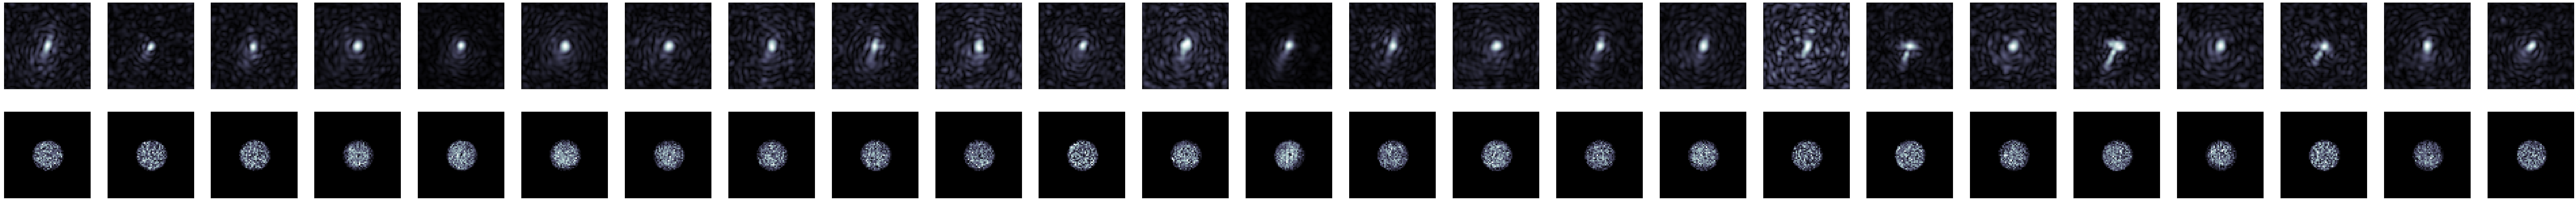

In [5]:
validation_set_size = min(validation_set_size, len(ROIdata["0pct_wGold"]))
validation_set = []
for trace in random.sample(ROIdata["0pct_wGold"], validation_set_size):
  validation_set.append(trace[np.random.randint(0, shortest_trace),...])

fig, ax = plt.subplots(2, validation_set_size, figsize=(validation_set_size*5, 10))
for i, img in enumerate(validation_set):
  ax[0, i].imshow(np.abs(img[..., 0]), cmap='bone')
  ax[0, i].set_xticks([])
  ax[0, i].set_yticks([])
  ax[1, i].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img[..., 0]))), cmap='bone')
  ax[1, i].set_xticks([])
  ax[1, i].set_yticks([])


32.0
45.254833995939045


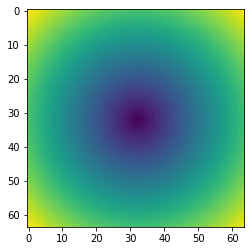

In [6]:
x = np.arange(IMAGE_SIZE) - IMAGE_SIZE/2
y = np.arange(IMAGE_SIZE) - IMAGE_SIZE/2
X, Y = np.meshgrid(x,y)
RHO = np.sqrt(X**2 + Y**2)
inds = np.argsort(RHO)


plt.imshow(RHO)

tst = RHO

print(RHO[0,32])
print(np.max(RHO))

'\nsteps=9\nfig, axs = plt.subplots(steps//3, steps//3, figsize=(steps//3*6,steps//3*6))\n\nfor i, ax in enumerate(axs.flatten()):\n  tmp = (0.1*np.random.randn(64, 64) + 0.1j * np.random.randn(64, 64)) * 3*i\n  tmp[RHO>=11]= 0\n  noisy_img = np.fft.ifft2(np.fft.ifftshift(fft_img+tmp))\n  ax.imshow(np.abs(noisy_img), cmap=\'bone\')\n  ax.set_xticks([])\n  ax.set_yticks([])\n\nplt.savefig("./test_white_noise", bbox_inches=\'tight\')\n'

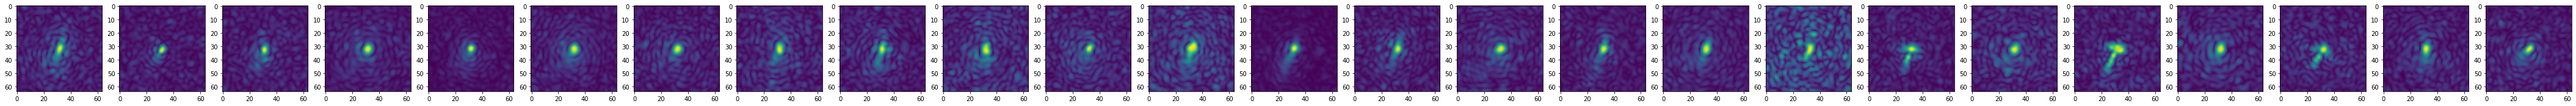

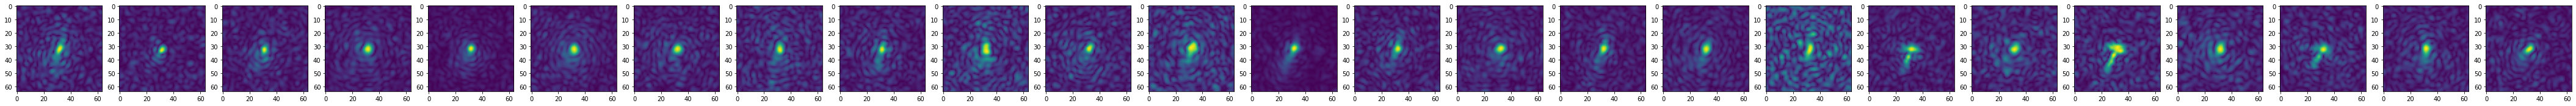

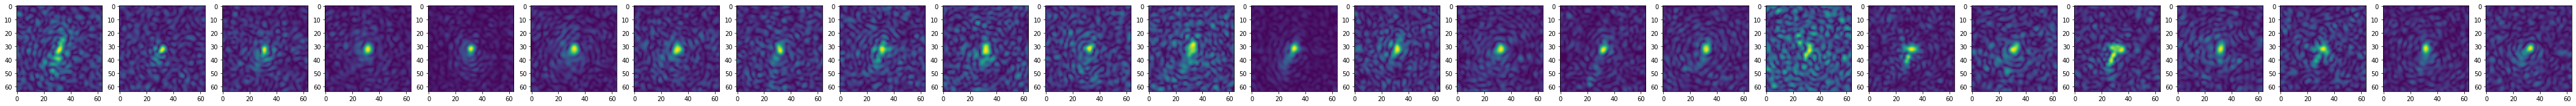

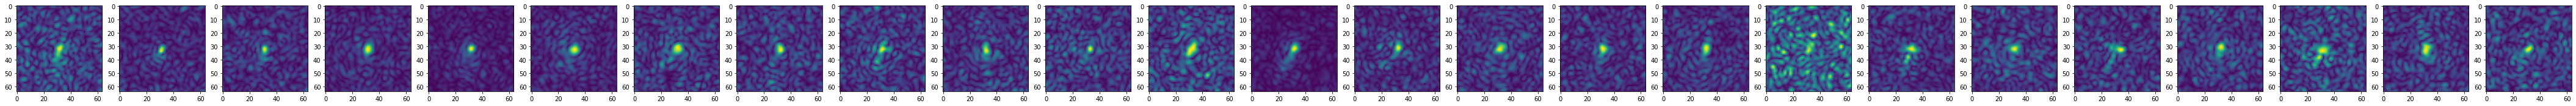

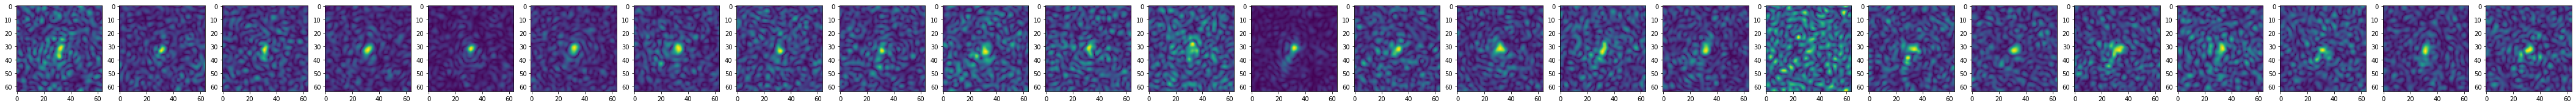

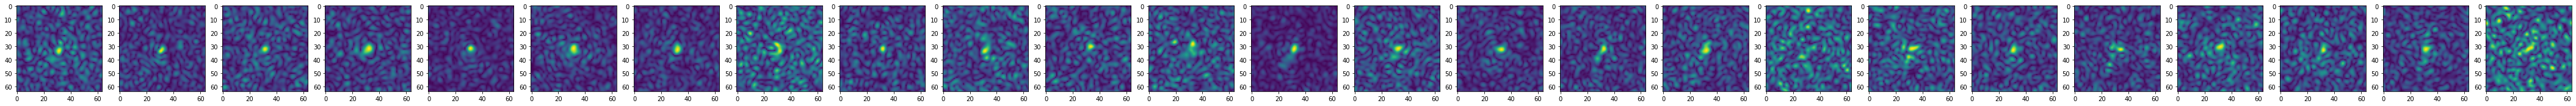

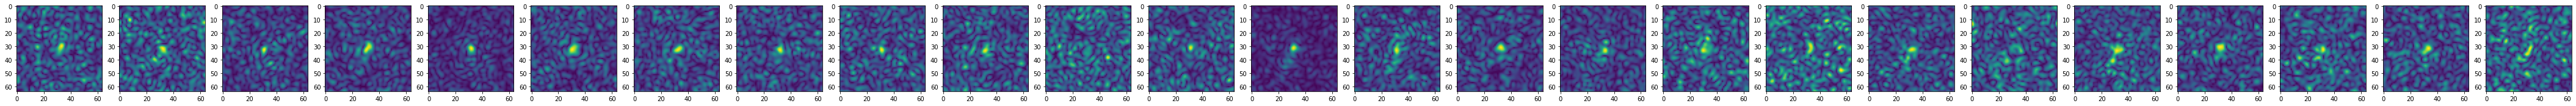

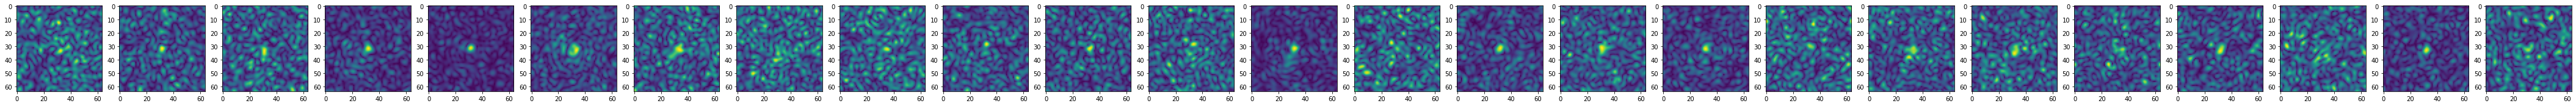

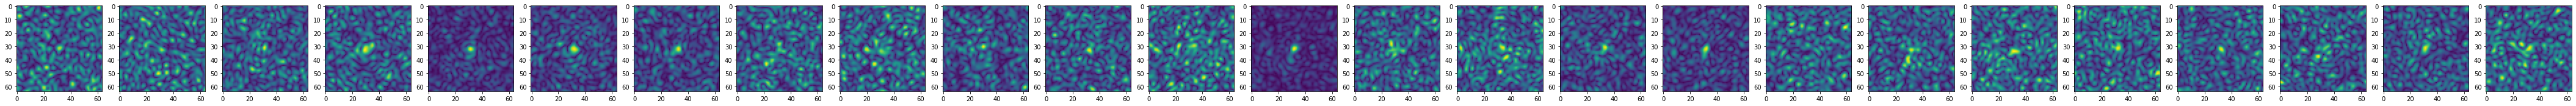

In [7]:
steps=9
noisy_sets = []
for i in range(steps):
  noisy_set=[]
  for img in validation_set:
    #img = random.choice(validation_set)[...,0]
    fft_img = np.fft.fftshift(np.fft.fft2(img[..., 0]))
    tmp = (0.1*np.random.randn(64, 64) + 0.1j * np.random.randn(64, 64)) * 4*i
    tmp[RHO>=11]= 0
    noisy_set.append(np.fft.ifft2(np.fft.ifftshift(fft_img+tmp)))
  noisy_sets.append(noisy_set)

for noisy_set in noisy_sets:
  fig, axs = plt.subplots(1, 25, figsize=(25*3, 3))
  for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.abs(noisy_set[i]))